# Deepdive into ResNets
In this notebook, we will look more in-depth at the ResNets to analyze why exactly they run like they do, where the computation time and memory is being used, and how exactly the bottleneck layers differ from plain implementations. For this experiment we will compare ResNets of size 50.

In [24]:
from resnet import resnet50, resnet50_bottleneck
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.profiler import profile, record_function, ProfilerActivity

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [25]:
def profile_model(model, inputs, labels, sort_by_string):
    model(inputs)   # Warmup

    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
                 profile_memory=True, record_shapes=True) as prof:
        with record_function("model_inference"):
            outputs = model(inputs)
        with record_function("loss"):
            loss = criterion(outputs, labels)
        with record_function("Backprogapation"):
            loss.backward()

    print(prof.key_averages().table(sort_by=sort_by_string, row_limit=15))

In [42]:
def trace_model(model, inputs, labels):
    model(inputs)   # Warmup

    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

    prof.export_chrome_trace("trace.json")

In [27]:
class Loader():
    def __init__(self, batch_size) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.path = "./data"

        self.transform_train = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.trainset = torchvision.datasets.CIFAR100(
            root=self.path, train=True, download=True, transform=self.transform_train)
        
        self.trainloader = torch.utils.data.DataLoader(
            self.trainset, batch_size=batch_size, shuffle=True, num_workers=2)
        
        self.trainloader_enum = enumerate(self.trainloader)

    def get_inputs(self):
        batch_idx, (inputs, targets) = next(self.trainloader_enum)
        inputs, targets = inputs.to(device), targets.to(device) 
        return inputs, targets



### Plain ResNet50

In [40]:
model = resnet50().to(device)
loader = Loader(batch_size=64)
inputs, labels = loader.get_inputs()
profile_model(model, inputs, labels, "self_cuda_time_total")

Files already downloaded and verified
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             aten::convolution_backward         4.19%       4.591ms        14.35%      15.709ms     436.361us      24.159ms        63.51%      25.005ms     694.583us           0 b   

Like seen previously, the vast majority of time is spent for convolution. We observe that roughly 63% is spent in the convolution backward pass, with a close second being the convolution forward pass at 24%. At third place, we have the underlying kernel for single-precision general matrix multiplication, demanding 14%. of the execution time, followed by the CUDNN call to winograd.

In [38]:
profile_model(model, inputs, labels, "self_cuda_memory_usage")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         2.38%       1.479ms         2.38%       1.479ms       4.097us       0.000us         0.00%       0.000us       0.000us           0 b           0 b     120.89 Mb     120.89 M

In [41]:
profile_model(model, inputs, labels, "cuda_memory_usage")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         2.79%       1.859ms         2.79%       1.859ms       5.150us       0.000us         0.00%       0.000us       0.000us           0 b           0 b     120.89 Mb     120.89 M

Similarly for memory consumption, the cudnn call to forward convolution requires a significant memory chunk. This is due to storing activations, where convolutional layers notoriously produce many activations while requiring fewer parameters. After this is convolution backward pass, where less memory is required to be stored - again, this is due to the activations that are stored during forward pass. Note here that "aten::empty" is the label for memory allocation, used throughout. Note in the second daiagram, however, that the backward pass requires over all more memory than the forward pass, where "model_inference" needs 39.84 Mb overall, compared to 98.4 Mb for the backward pass.

## Tracing
Let's investigate the trace next. The trace file will be saved upon execution of the next block, and is also available in the github repo.

In [43]:
trace_model(model, inputs, labels)

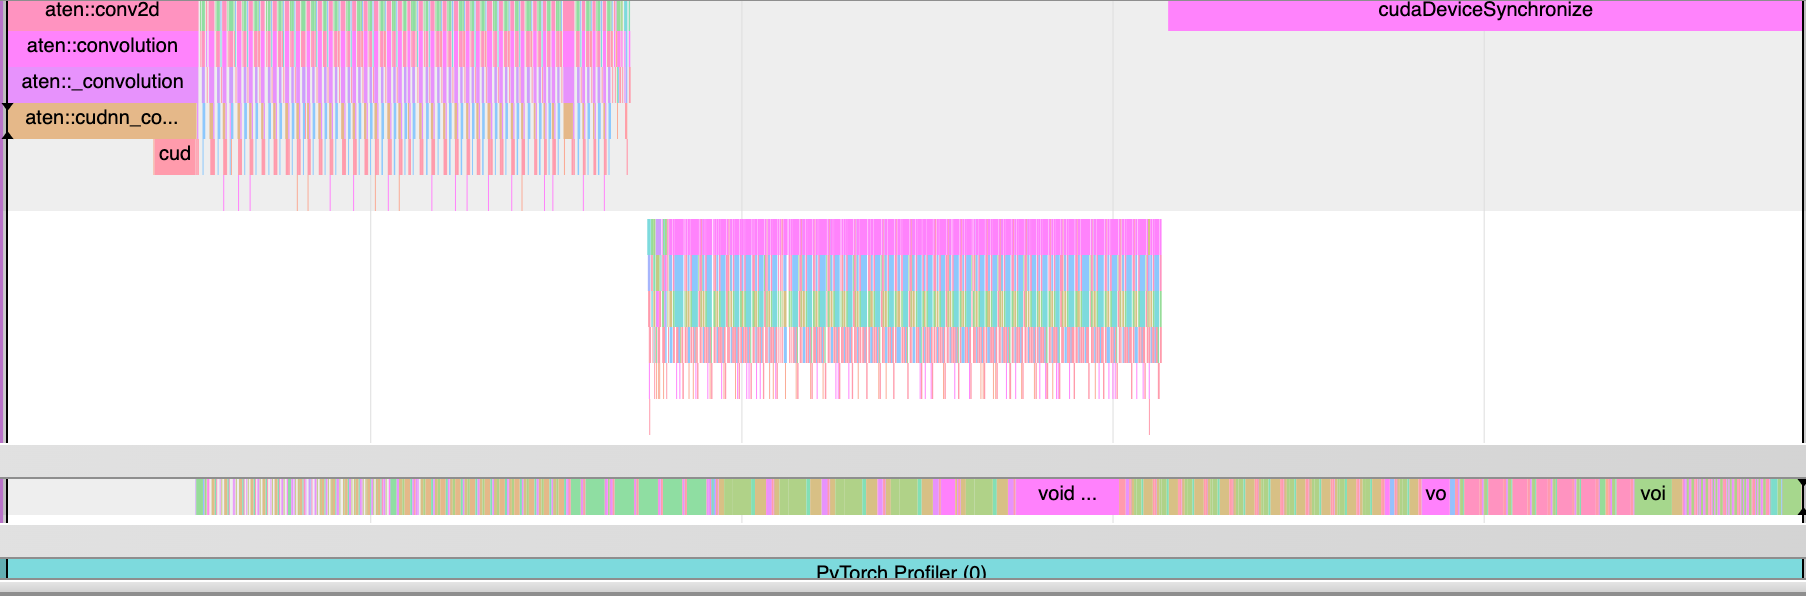

Here we can see the trace file, where the top two broad strips are processes on CPU, and the bottom thin strip, just above the "PyTorch Profiler" section, is the GPU. The forward pass is launched on the top CPU process, after which it abruplty ends and shifts to backward pass on the second process. Finally, it returns to the first process for CUDA synchronization while the GPU finishes processing. Throughout, the GPU processes the computations launched by the CPU. Let's examine the flow of events from the CPU to the GPU.

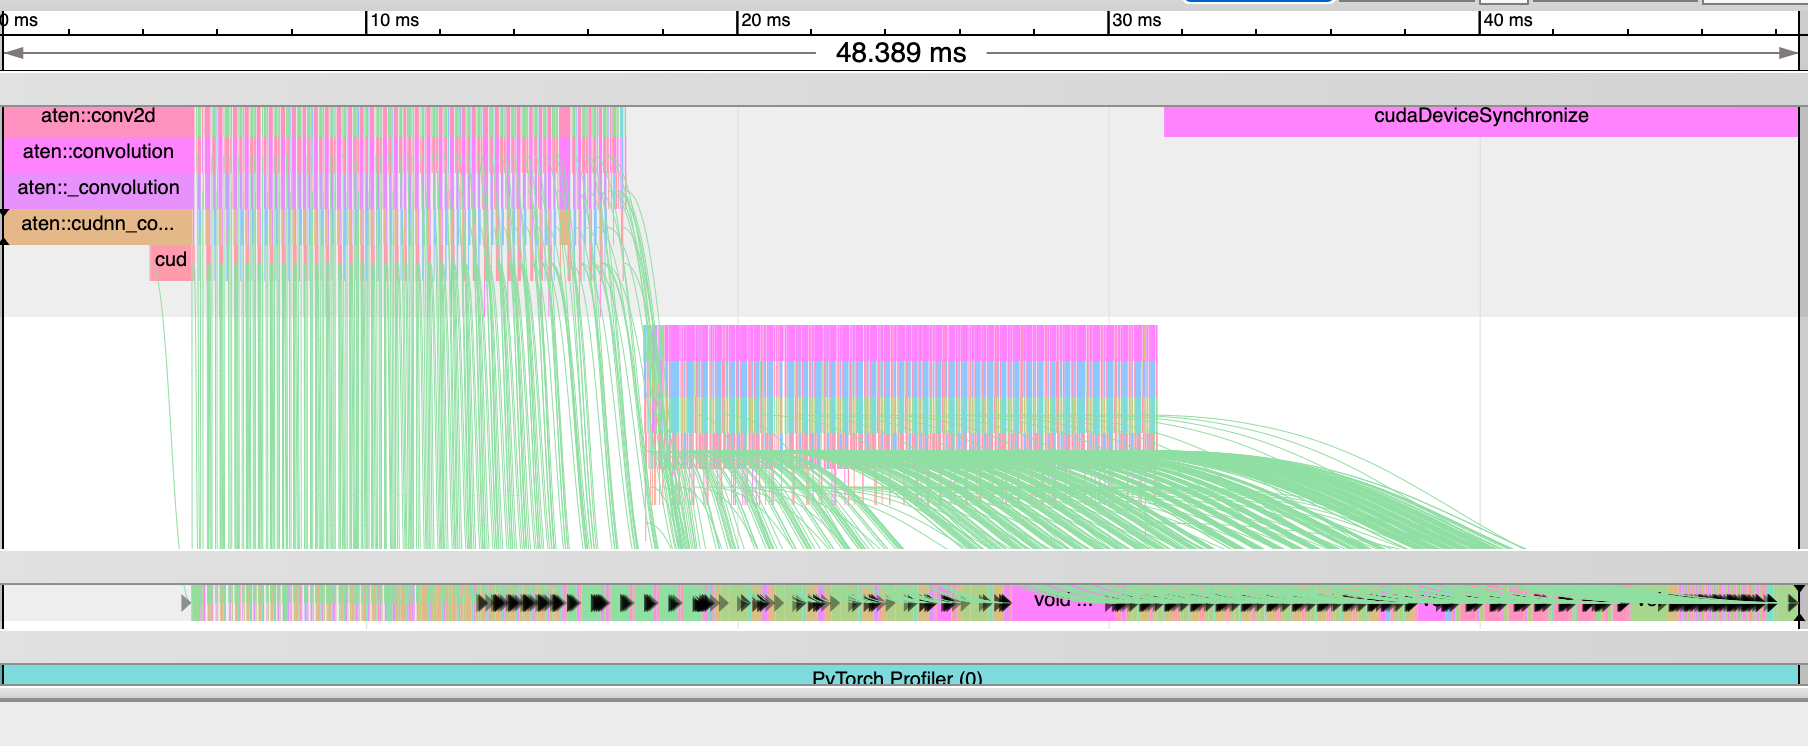

Notice that for the forward pass, the GPU (which performs most of the heavy processing) is almost able to keep up with the kernels launched by the CPU, lagging behind only somewhat. Observe especially the turning point halfway through the following graph:

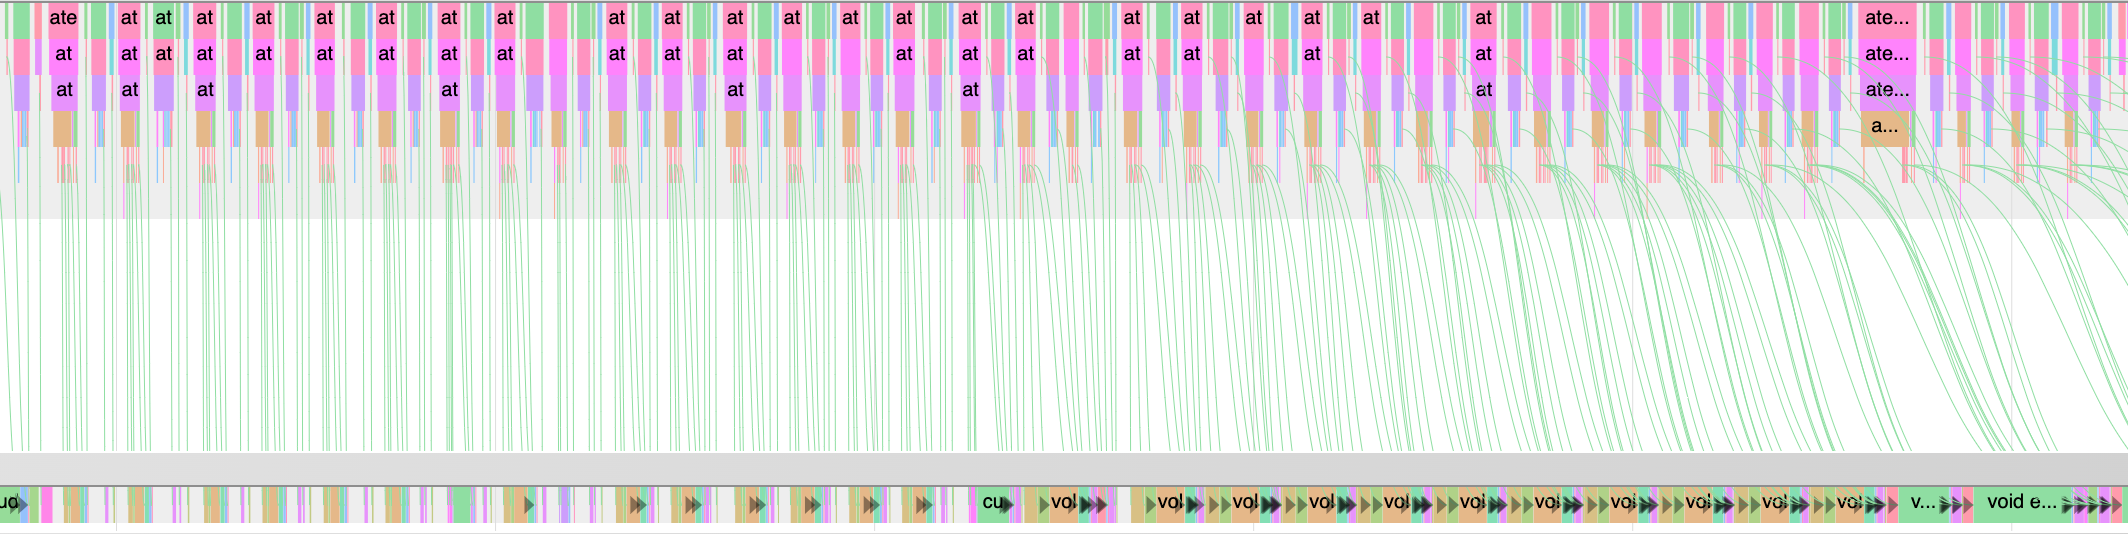

The computations get noticably more dense, and the GPU startslagging behind. There's a second turning point where the computations get even more time-consuming:

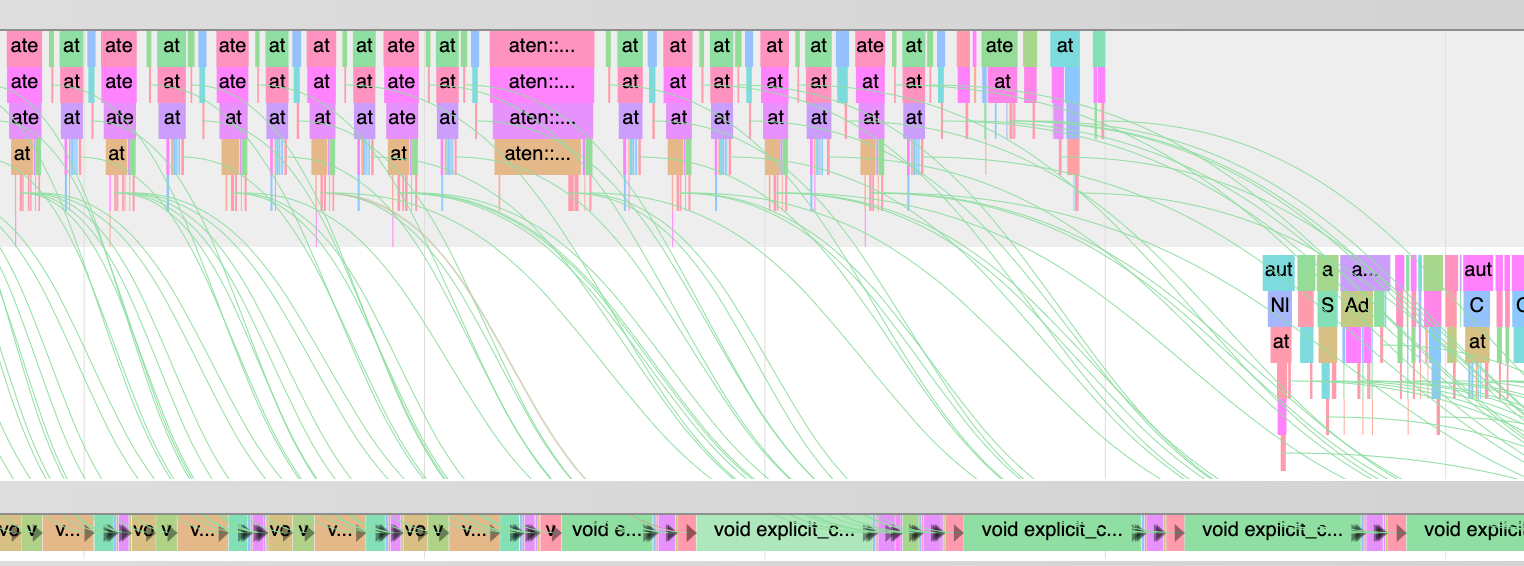

In the trace file we notice that these operations are "SGEMM" and "explicit_convolve_sgemm" - i.e., matrix multiplications forward. The increases in computation time occur when the channels are upscaled.

For the backward pass, the computation is much more intensive as also seen from the PyTorch profiler, and the GPU lags much further behind the processes launched by the CPU. The trace shows that the larger and slower blocks are ConvolutionBackward0 and the nested aten:convolution_backward on the CPU, and on the GPU it is the "volta_sgemm" and cudnn Winograd kernels that take much longer.


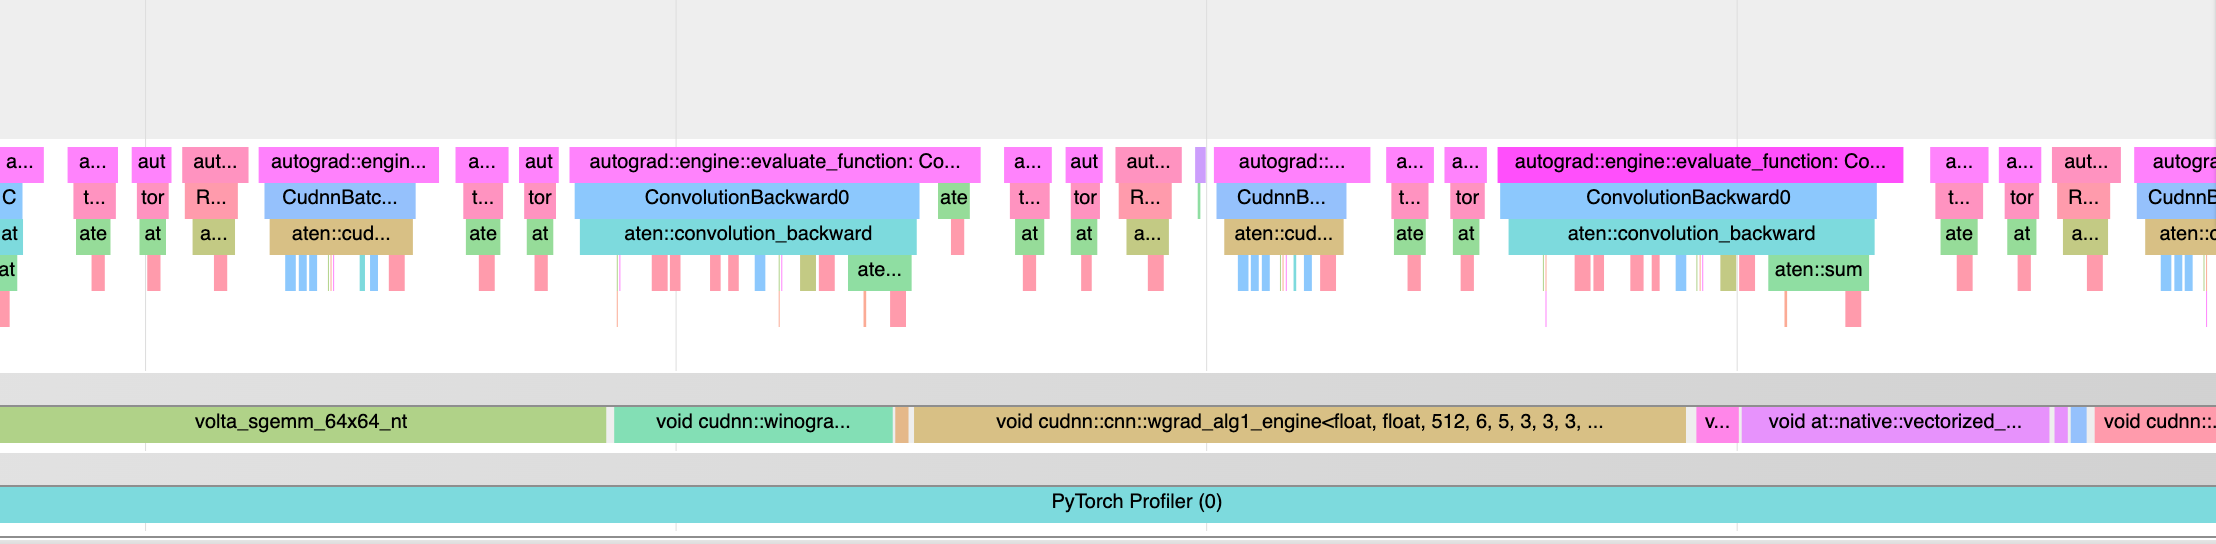

### Bottleneck ResNet50

In [ ]:
model = resnet50_bottleneck().to(device)
inputs, labels = loader.get_inputs()
trace_model(model, inputs, labels)

Observe the trace of the bottleneck implementation:

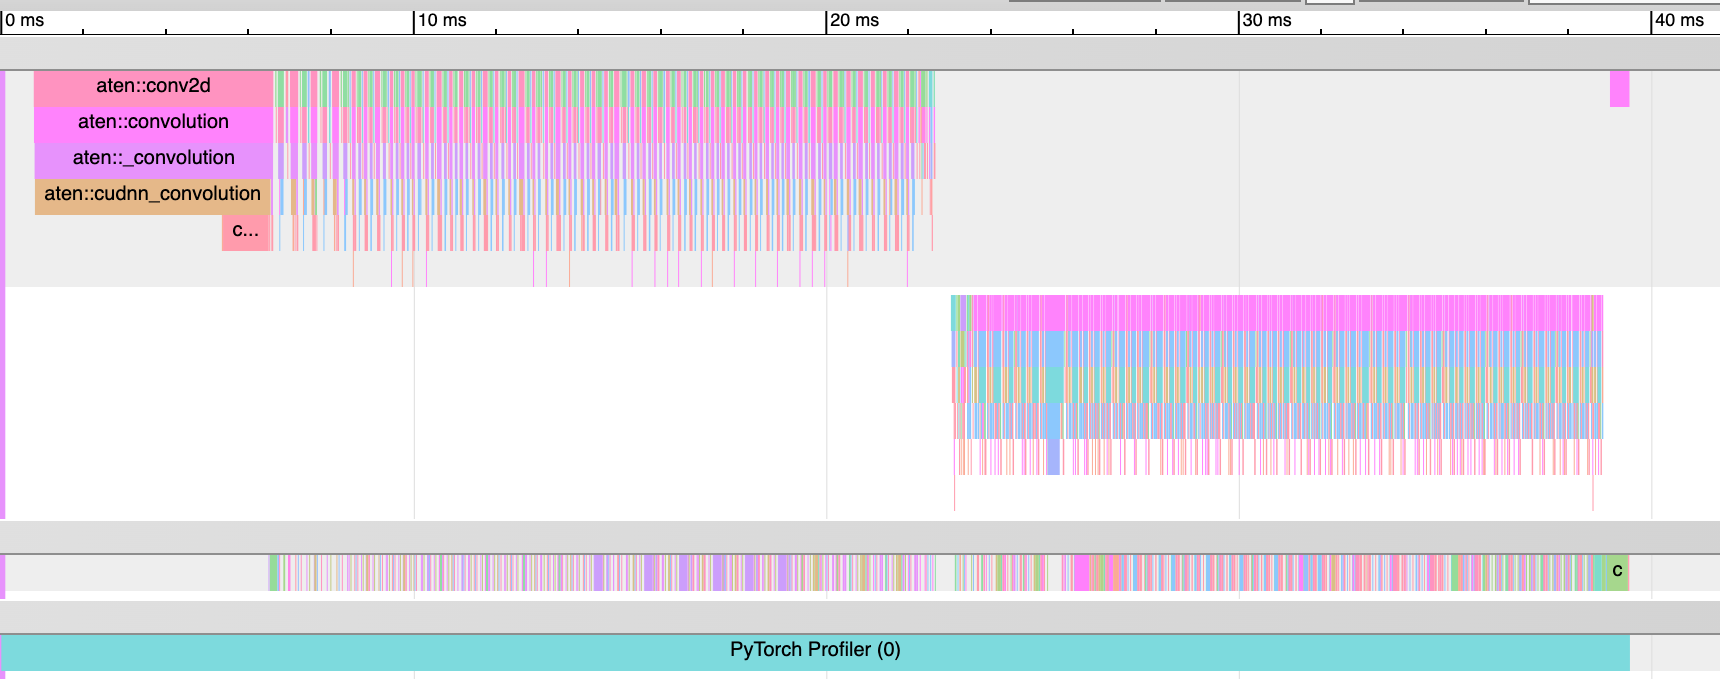

This is astounding. Even during the backward pass, the model is able to keep up with the CPU kernel launches almost perfectly, lagging behind only by a tiny sliver. Again, we note that the majority of the computation is performed by the matrix multiplication kernels, such as Winograd:

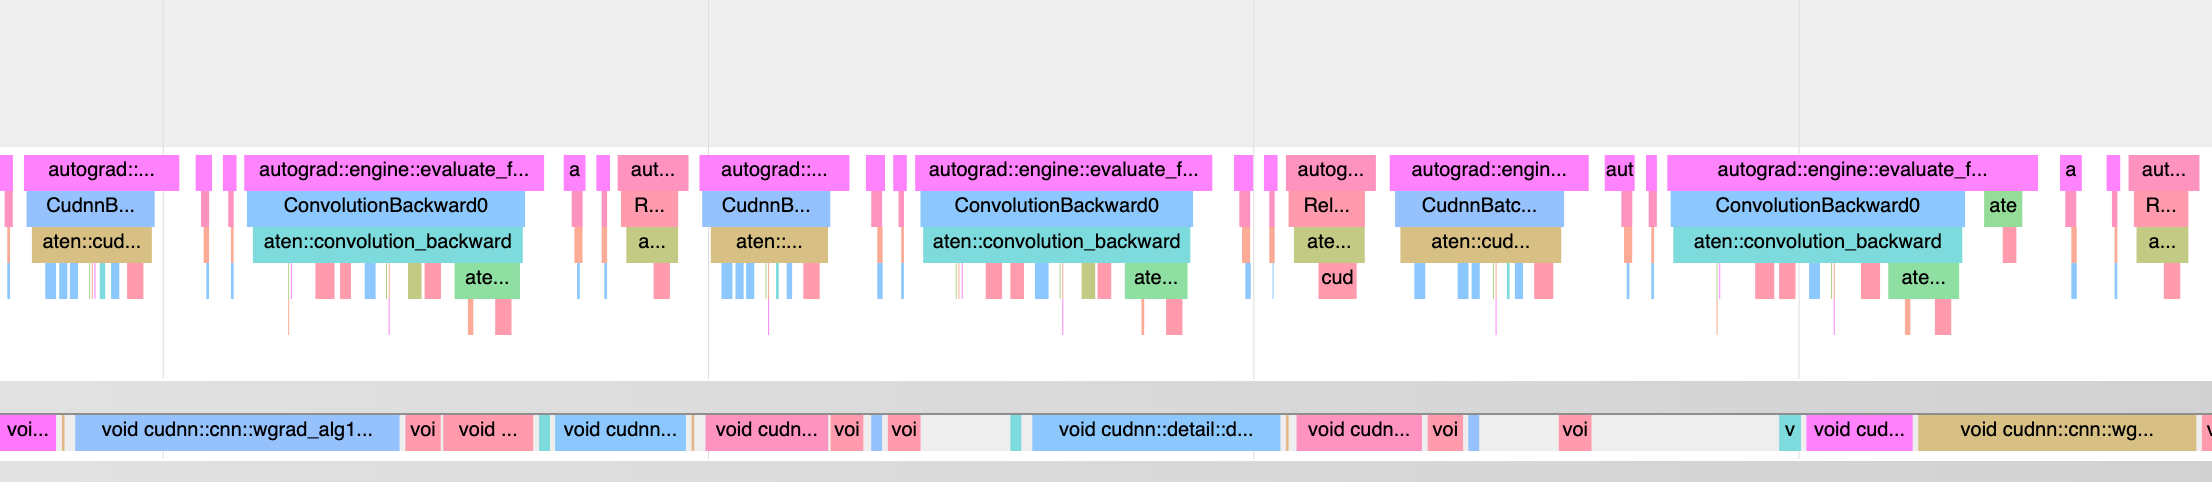

Though the matrix multiplication still take up a good majority of the GPU time, they are now much quicker than before, closing in on smaller operations like Relu. 

This is an important demonstration of the efficiency of Bottleneck ResNets. We have seen that a huge portion of the computation load lies with the convolution, and especially in the backward pass. We saw that the plain ResNets experienced significant slowdown from the point of kernel launch until completion, but we were able to reduce the computation time such that it almost is as quick as the kernel launch and CPU activity itself.

### VGG-16

In [50]:
from vgg16 import VGG16
model = VGG16().to(device)
inputs, labels = loader.get_inputs()
trace_model(model, inputs, labels)

VGG16 suffers from the same issues as the plain ResNets do, but to an even more exaggerated extent. Observe the VGG16 trace:

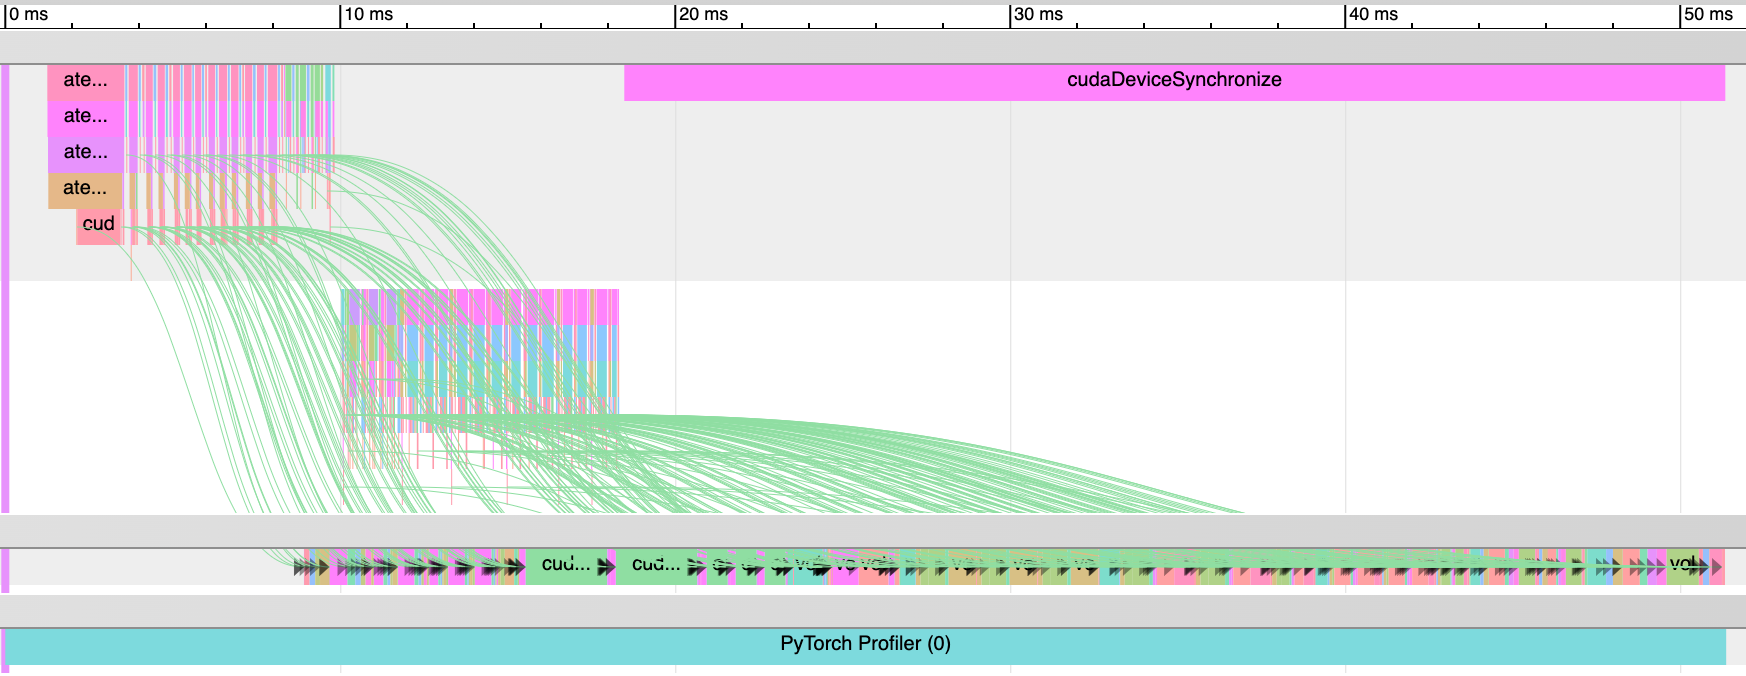

For the CPUs, we can see that the number of kernels launched is actually quite small, certainly much fewer than for ResNets. Yet a significantly longer time is spent computing these kernels, and the final computation doesn't finish until a full 30ms after the last backward kernel launches from the CPU. Strangely enough, there is a significant delay between the forward kernel launches on the CPU and the beginning of the calculations on GPU.

Again, the majority of kernels on the GPU are matrix multiplications:

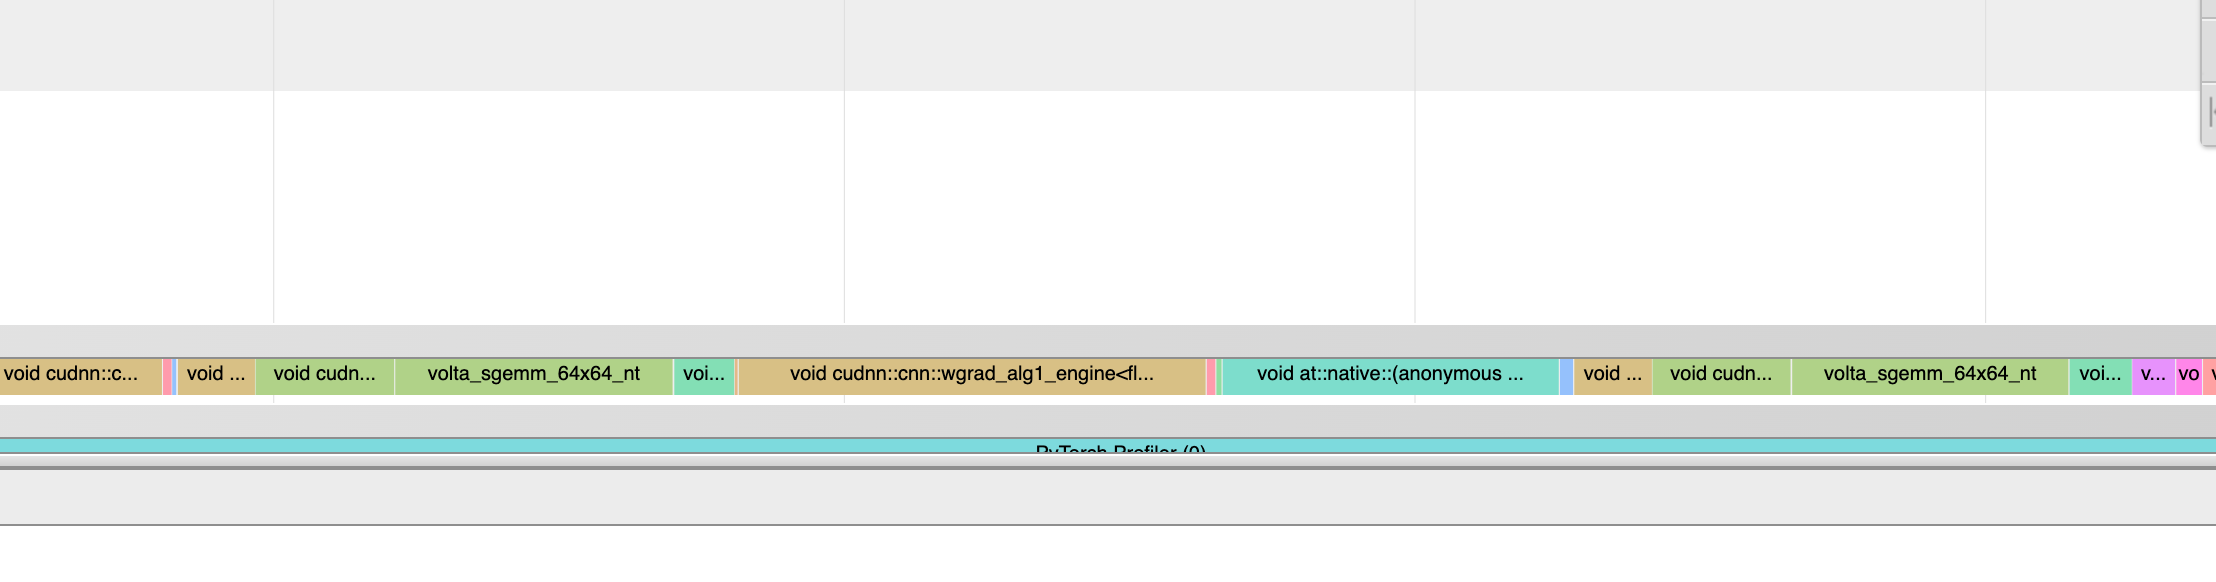

This clearly shows the advantage of ResNets over VGG style networks, and the utility and. potential of bottleneck layers. These layers allow for significantly deeper networks (and thus more non-linearity) than implementations without them.